<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/trade/Trade_Hourly_Moumita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!pip install pandas-ta --q
!pip install logzero --q
!pip install smartapi-python==1.4.1 --q
!pip install pyotp --q

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas_ta as ta

In [51]:
# package import statement
from SmartApi import SmartConnect #or from SmartApi.smartConnect import SmartConnect
import pyotp
from logzero import logger
import time
import os
import urllib
import json
import pandas as pd
import datetime as dt

api_key = 'xOHnB7MG'
username = 'M55123447'
pwd = '1471'
smartApi = SmartConnect(api_key)
try:
    token = "GJZACUQI2TTAIBHBA34XNFJURQ"
    totp = pyotp.TOTP(token).now()
except Exception as e:
    logger.error("Invalid Token: The provided token is not valid.")
    raise e

correlation_id = "abcde"
data = smartApi.generateSession(username, pwd, totp)

if data['status'] == False:
    logger.error(data)

else:
    # login api call
    # logger.info(f"You Credentials: {data}")
    authToken = data['data']['jwtToken']
    refreshToken = data['data']['refreshToken']
    # fetch the feedtoken
    feedToken = smartApi.getfeedToken()
    # fetch User Profile
    res = smartApi.getProfile(refreshToken)
    smartApi.generateToken(refreshToken)
    res=res['data']['exchanges']


In [52]:
#Download Nifty50 Index Data
params = {
           "exchange": "NSE",
           "symboltoken": '99926000',
           "interval": "ONE_HOUR",
           "fromdate": (dt.date.today() - dt.timedelta(25)).strftime('%Y-%m-%d %H:%M'),
           "todate": (dt.date.today()+dt.timedelta(days=1)).strftime('%Y-%m-%d %H:%M')
         }
nifty_data = smartApi.getCandleData(params)
nifty_test= pd.DataFrame(nifty_data["data"],
                               columns = ["Date","Open","High","Low","Close","Volume"])
nifty_test.set_index("Date",inplace=True)
nifty_test.index = pd.to_datetime(nifty_test.index)
nifty_test.index = nifty_test.index.tz_localize(None)

In [53]:
def calculate_technical_indicators(df, fast_macd=12, slow_macd=26, signal_macd=9, vortex_length=8, aroon_length=8, rsi_length=8):
    """
    Calculates and appends technical indicators to a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        fast_macd (int, optional): Fast period for MACD. Defaults to 12.
        slow_macd (int, optional): Slow period for MACD. Defaults to 26.
        signal_macd (int, optional): Signal period for MACD. Defaults to 9.
        vortex_length (int, optional): Length for Vortex indicator. Defaults to 18.
        aroon_length (int, optional): Length for Aroon indicator. Defaults to 18.
        rsi_length (int, optional): Length for RSI indicator. Defaults to 18.

    Returns:
        pd.DataFrame: The DataFrame with the calculated indicators appended.
    """
    for t in [0.25,0.5,0.75]:

      df.ta.macd(fast=fast_macd, slow=slow_macd, signal=signal_macd, append=True)
      df.ta.macd(fast=int(fast_macd * t), slow=int(slow_macd * t), signal=int(signal_macd * t), append=True)
      df.ta.vortex(length=vortex_length, append=True)
      df.ta.aroon(length=aroon_length, append=True)
      df.ta.rsi(length=rsi_length, append=True)
      df.ta.vortex(length=int(vortex_length * t), append=True)
      df.ta.aroon(length=int(aroon_length * t), append=True)
      df.ta.rsi(length=int(rsi_length * t), append=True)
    return df

In [54]:
def calculate_recent_price_action_features(df):
    """
    Calculate recent price action features for a given DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame with 'Date' as index and 'Close', 'Open', 'High', 'Low' columns

    Returns:
    pd.DataFrame: DataFrame with additional columns for recent price action features
    """

    # Ensure the DataFrame is sorted by date
    df = df.sort_index()

    # 1. Previous day's return
    df['prev_day_return'] = df['Close'].pct_change()

    # 2. Weekly return (5 trading days)
    df['weekly_return'] = df['Close'].pct_change(periods=5)

    # 3. Monthly return (21 trading days)
    df['monthly_return'] = df['Close'].pct_change(periods=21)

    # 4. Price momentum (3-day, 5-day, 10-day)
    for period in [3, 5, 10]:
        df[f'momentum_{period}d'] = df['Close'].pct_change(periods=period)

    # 5. Gap
    df['gap'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)

    # 6. Intraday price range
    df['intraday_range'] = (df['High'] - df['Low']) / df['Close']

    # 7. Distance from moving averages (5-day, 10-day MA)
    for period in [5, 10]:
        ma = df['Close'].rolling(window=period).mean()
        df[f'dist_from_ma_{period}d'] = (df['Close'] - ma) / ma

    # 8. Recent highs and lows (5-day window)
    df['near_high_5d'] = df['Close'] >= df['High'].rolling(window=5).max()
    df['near_low_5d'] = df['Close'] <= df['Low'].rolling(window=5).min()

    return df

In [55]:
nifty_test=calculate_technical_indicators(nifty_test)
nifty_test=calculate_recent_price_action_features(nifty_test)
df = nifty_test.copy()
# I Just need the Close
price_data_new = df.copy()


In [56]:
price_data_new.shape

(116, 53)

In [57]:
features = price_data_new.columns.tolist()
# Group by the `Symbol` column, then grab the `Close` column.
#close_groups = price_data_new['Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
#close_groups = close_groups.transform(lambda x : np.sign(x.diff(days_out)))

# add the data to the main dataframe.
#price_data_new['Prediction'] = close_groups
price_data_new = price_data_new.dropna()

X_test_new =price_data_new[features]
#Y_Cols = price_data_new['Prediction']

In [58]:
import requests
import joblib

In [59]:
# Load model from the saved file
!wget https://github.com/anirbanghoshsbi/.github.io/raw/master/work/models/model_L1_0.pkl -O model_L1_0.pkl
!wget https://github.com/anirbanghoshsbi/.github.io/raw/master/work/models/model_L1_1.pkl -O model_L1_1.pkl
!wget https://github.com/anirbanghoshsbi/.github.io/raw/master/work/models/model_L1_2.pkl -O model_L1_2.pkl
!wget https://github.com/anirbanghoshsbi/.github.io/raw/master/work/models/model_L1_3.pkl -O model_L1_3.pkl
!wget https://github.com/anirbanghoshsbi/.github.io/raw/master/work/models/model_L1_4.pkl -O model_L1_4.pkl
model_1=joblib.load('model_L1_0.pkl')
model_2=joblib.load('model_L1_1.pkl')
model_3=joblib.load('model_L1_2.pkl')
model_4=joblib.load('model_L1_3.pkl')
model_5=joblib.load('model_L1_4.pkl')
print("All models loaded successfully.")


--2025-03-10 06:47:36--  https://github.com/anirbanghoshsbi/.github.io/raw/master/work/models/model_L1_0.pkl
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/anirbanghoshsbi/.github.io/master/work/models/model_L1_0.pkl [following]
--2025-03-10 06:47:36--  https://raw.githubusercontent.com/anirbanghoshsbi/.github.io/master/work/models/model_L1_0.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2415 (2.4K) [application/octet-stream]
Saving to: ‘model_L1_0.pkl’

model_L1_0.pkl      100%[===================>]   2.36K  --.-KB/s    in 0s      

2025-03-10 06:47:36 (22.0 MB/s) - ‘model_L1_0.pkl’ save

In [60]:
#[4] Then new test set (X_test_new) comes. We load our 1st level models and predict new test set to get stacked features (S_test_new):
y_pred_L1_0 = model_1.predict(X_test_new)
y_pred_L1_1 = model_2.predict(X_test_new)
y_pred_L1_2 = model_3.predict(X_test_new)
y_pred_L1_3 = model_4.predict(X_test_new)
y_pred_L1_4 = model_5.predict(X_test_new)

#y_pred_l1_6= model_L1_X.predict(X_test_new)
S_test_new = np.c_[y_pred_L1_0, y_pred_L1_1,y_pred_L1_2,y_pred_L1_3,y_pred_L1_4]

In [61]:
y_pred_new_p = S_test_new.sum(axis=1)
buy= np.where(y_pred_new_p>=0)
sell= np.where(y_pred_new_p<0) #0 if impulse !!!


In [62]:
price_data_new.reset_index(inplace=True)
df.reset_index(inplace=True)

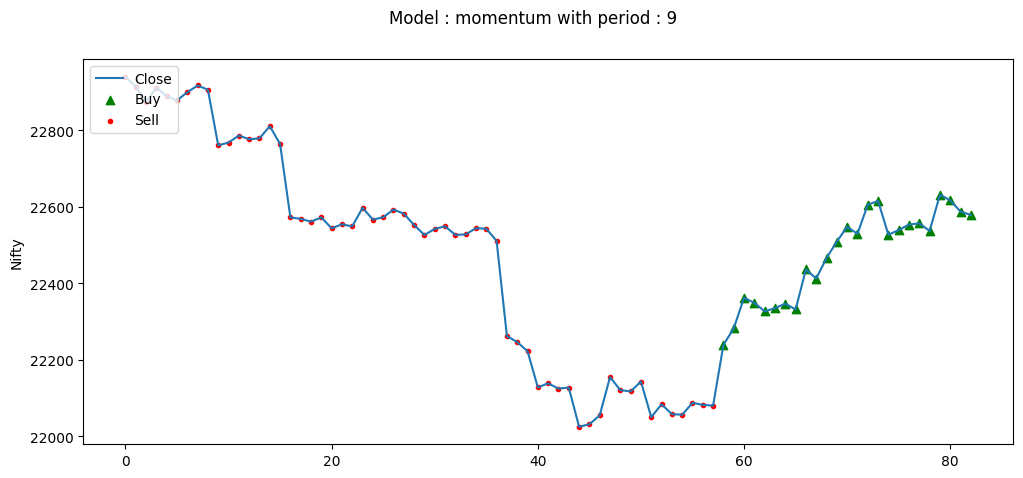

In [63]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,5))  # single Axes object

# Plot data
ax.plot(price_data_new.loc[:, :].index, price_data_new.loc[:, 'Close'], label='Close')

# (Optional) If you want to plot the predictions on the same axis:
# ax.plot(price_data_new.loc[:, :].index, y_pred_new_p, label='Nifty')

# Scatter buy/sell points
ax.scatter(price_data_new.iloc[buy].index,
           price_data_new.iloc[buy].Close,
           marker='^',
           label='Buy',
           color='g')
ax.scatter(price_data_new.iloc[sell].index,
           price_data_new.iloc[sell].Close,
           marker='.',
           label='Sell',
           color='r')

ax.legend(loc='upper left')
ax.set_ylabel('Nifty')

fig.suptitle('Model : ' + 'momentum' + ' with period : ' + str(9))

plt.savefig('ml.png')
plt.show()
